Data Overview:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.421776   0.574011   0.599583   0.479369   0.509436   0.519414   
1   0.086067   0.148184   0.152437   0.115488   0.161196   0.144720   
2   0.280018   0.396211   0.411088   0.327705   0.365325   0.362988   
3   0.044752   0.091481   0.096576   0.066178   0.111749   0.093948   
4   0.435670   0.591882   0.617901   0.494919   0.525206   0.535559   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_248  Feature_249  \
0   0.574690   0.495442   0.531326    0.494106  ...     3.955962    -2.599507   
1   0.154916   0.172746   0.145424    0.130367  ...     1.416205     2.409825   
2   0.399500   0.365175   0.371011    0.344062  ...    -1.774577     0.417372   
3   0.097663   0.119082   0.093101    0.079053  ...     1.845771    -6.682148   
4   0.592540   0.511974   0.548630    0.510616  ...    -1.638498     0.237464   

   Feature_250  Feature_251  Feature_252  Feature_253  Feature_254  \
0

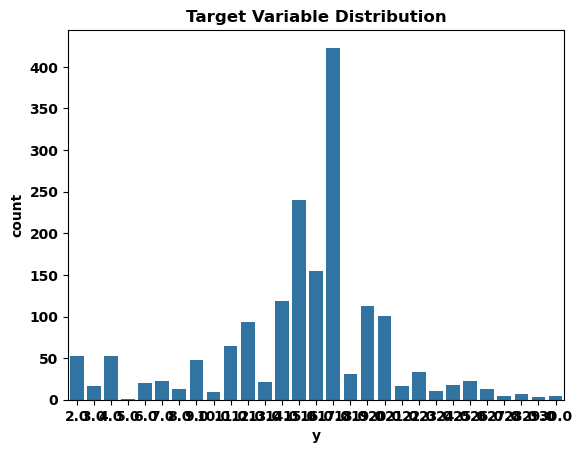

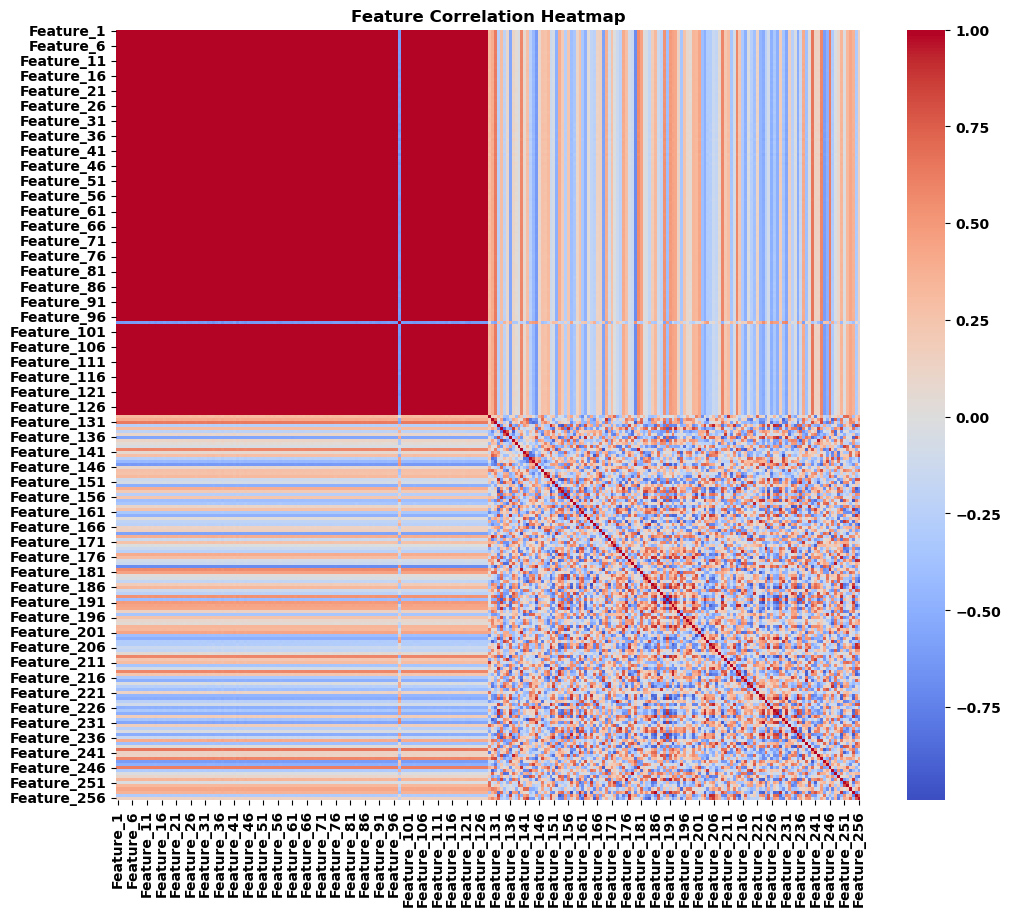

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns


# Set random seed for reproducibility
seed = 42  # You can choose any integer here

# Set seed for NumPy
np.random.seed(seed)

# Set seed for Python's random module
random.seed(seed)

# Set seed for PyTorch
torch.manual_seed(seed)

# For GPU (if using CUDA)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set deterministic behavior for reproducibility in case of CUDA operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False




dataset_dir = "datasets/"

# Directory containing the saved CSV files
output_dir = dataset_dir + "training_outputs/"

# Load one of the CSV files for EDA (e.g., user_0_outputs.csv)
csv_file = os.path.join(output_dir, "user_1_outputs.csv")
df = pd.read_csv(csv_file)

# Quick overview of the data
print("Data Overview:")
print(df.head())
print("\nData Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of the target variable (y)
sns.countplot(x="y", data=df)
plt.title("Target Variable Distribution")
plt.show()

# Correlation heatmap of features
correlation_matrix = df.iloc[:, :-1].corr()  # Exclude the target column
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [2]:


# Define the Multinomial Logistic Regression model
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultinomialLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

# Custom dataset to load the data from CSV
class CustomDataset(Dataset):
    def __init__(self, csv_file, scaler=None):
        self.data = pd.read_csv(csv_file)
        self.X = self.data.iloc[:, :-1].values  # Features
        self.y = self.data.iloc[:, -1].values   # Labels

        # If a scaler is provided, use it to transform the features
        if scaler:
            self.X = scaler.transform(self.X)
        else:
            # Fit the scaler on the training data and transform
            self.scaler = MinMaxScaler(feature_range=(-1, 1))
            self.X = self.scaler.fit_transform(self.X)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets
        return X, y



In [3]:
no_users = 20
# List to store DataLoader objects for each user
train_loaders = []
val_loaders = []
test_loaders = []
scaler = None
# Loop over each user
for user_idx in range(no_users):
    # Define file paths for each user dynamically
    train_file = dataset_dir + f"training_outputs/user_{user_idx}_outputs.csv"
    val_file = dataset_dir + f"val_outputs/user_{user_idx}_outputs.csv"
    test_file = dataset_dir + f"test_outputs/user_{user_idx}_outputs.csv"

    # Load training data and fit the scaler on it (only once for each user)
    train_data = pd.read_csv(train_file)
    
    if scaler is None:
        # Fit the scaler on the first user's training data
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(train_data.iloc[:, :-1].values)  # Fit scaler only on training features

    # Create datasets using the same scaler for all data
    train_dataset = CustomDataset(train_file, scaler=scaler)
    val_dataset = CustomDataset(val_file, scaler=scaler)
    test_dataset = CustomDataset(test_file, scaler=scaler)

    # Create DataLoader for training, validation, and testing for each user
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Append each user's DataLoader to the respective lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
    test_loaders.append(test_loader)

In [15]:
# Initialize model, loss function, and optimizer for multiple users
input_size = 256  # Number of features
num_classes = 64
classifiers = [MultinomialLogisticRegression(input_size, num_classes) for _ in range(no_users)]
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in classifiers]
criterion = nn.CrossEntropyLoss()
# Training parameters
num_epochs = 100

# Track metrics across all users
train_loss_histories = []
val_loss_histories = []
train_accuracy_histories = []
val_accuracy_histories = []

# Training loop
for epoch in range(num_epochs):
    user_train_losses = []
    user_val_losses = []
    user_train_accuracies = []
    user_val_accuracies = []

    for user_id, (model, optimizer) in enumerate(zip(classifiers, optimizers)):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        for X_batch, y_batch in train_loaders[user_id]:  # Assuming train_loader is a list of loaders for users
            #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_train_predictions += (predicted == y_batch).sum().item()
            total_train_samples += y_batch.size(0)

        avg_train_loss = epoch_train_loss / len(train_loaders[user_id])
        train_accuracy = correct_train_predictions / total_train_samples

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loaders[user_id]:  # Assuming val_loader is a list of loaders for users
                #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                correct_val_predictions += (predicted == y_batch).sum().item()
                total_val_samples += y_batch.size(0)

        avg_val_loss = epoch_val_loss / len(val_loaders[user_id])
        val_accuracy = correct_val_predictions / total_val_samples

        user_train_losses.append(avg_train_loss)
        user_train_accuracies.append(train_accuracy)
        user_val_losses.append(avg_val_loss)
        user_val_accuracies.append(val_accuracy)

    # Store the averages and standard deviations across users
    train_loss_histories.append(user_train_losses)
    train_accuracy_histories.append(user_train_accuracies)
    val_loss_histories.append(user_val_losses)
    val_accuracy_histories.append(user_val_accuracies)

    # Print average metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Train Loss: {np.mean(user_train_losses):.4f}, Avg Train Accuracy: {np.mean(user_train_accuracies):.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Val Loss: {np.mean(user_val_losses):.4f}, Avg Val Accuracy: {np.mean(user_val_accuracies):.4f}")




C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_36712\2584759438.py:30: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets


Epoch [1/100], Avg Train Loss: 2.7942, Avg Train Accuracy: 0.4197
Epoch [1/100], Avg Val Loss: 1.8243, Avg Val Accuracy: 0.6232
Epoch [2/100], Avg Train Loss: 1.4454, Avg Train Accuracy: 0.6848
Epoch [2/100], Avg Val Loss: 1.2139, Avg Val Accuracy: 0.7227
Epoch [3/100], Avg Train Loss: 1.0614, Avg Train Accuracy: 0.7452
Epoch [3/100], Avg Val Loss: 0.9882, Avg Val Accuracy: 0.7512
Epoch [4/100], Avg Train Loss: 0.8965, Avg Train Accuracy: 0.7706
Epoch [4/100], Avg Val Loss: 0.8713, Avg Val Accuracy: 0.7701
Epoch [5/100], Avg Train Loss: 0.8018, Avg Train Accuracy: 0.7860
Epoch [5/100], Avg Val Loss: 0.7977, Avg Val Accuracy: 0.7840
Epoch [6/100], Avg Train Loss: 0.7386, Avg Train Accuracy: 0.7981
Epoch [6/100], Avg Val Loss: 0.7464, Avg Val Accuracy: 0.7945
Epoch [7/100], Avg Train Loss: 0.6929, Avg Train Accuracy: 0.8081
Epoch [7/100], Avg Val Loss: 0.7084, Avg Val Accuracy: 0.8025
Epoch [8/100], Avg Train Loss: 0.6582, Avg Train Accuracy: 0.8161
Epoch [8/100], Avg Val Loss: 0.6791, A

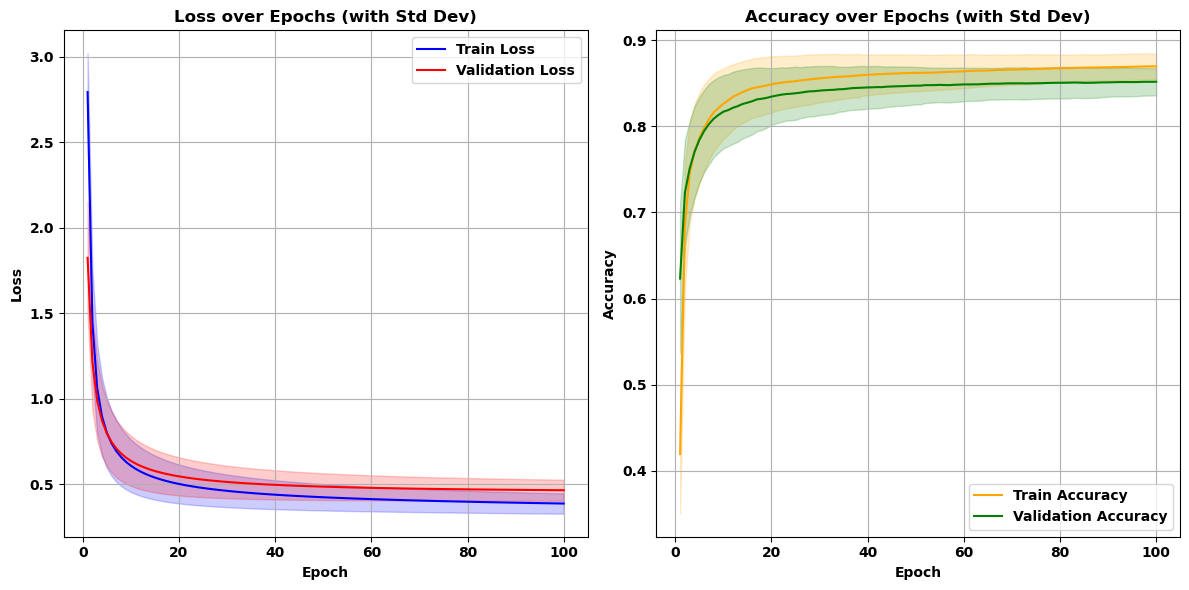

In [16]:
# Convert metrics to numpy arrays for easy manipulation
train_loss_histories = np.array(train_loss_histories)
train_accuracy_histories = np.array(train_accuracy_histories)
val_loss_histories = np.array(val_loss_histories)
val_accuracy_histories = np.array(val_accuracy_histories)

# Calculate means and standard deviations
train_loss_mean = train_loss_histories.mean(axis=1)
train_loss_std = train_loss_histories.std(axis=1)
val_loss_mean = val_loss_histories.mean(axis=1)
val_loss_std = val_loss_histories.std(axis=1)

train_acc_mean = train_accuracy_histories.mean(axis=1)
train_acc_std = train_accuracy_histories.std(axis=1)
val_acc_mean = val_accuracy_histories.mean(axis=1)
val_acc_std = val_accuracy_histories.std(axis=1)

# Plot metrics
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_mean, label="Train Loss", color="blue")
plt.fill_between(range(1, num_epochs + 1), train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color="blue", alpha=0.2)
plt.plot(range(1, num_epochs + 1), val_loss_mean, label="Validation Loss", color="red")
plt.fill_between(range(1, num_epochs + 1), val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color="red", alpha=0.2)
plt.title("Loss over Epochs (with Std Dev)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_mean, label="Train Accuracy", color="orange")
plt.fill_between(range(1, num_epochs + 1), train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, color="orange", alpha=0.2)
plt.plot(range(1, num_epochs + 1), val_acc_mean, label="Validation Accuracy", color="green")
plt.fill_between(range(1, num_epochs + 1), val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color="green", alpha=0.2)
plt.title("Accuracy over Epochs (with Std Dev)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_36712\2584759438.py:30: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets



Average Test Loss: 0.4838, Average Test Accuracy: 0.8447

Average Train Loss: 0.3782, Average Train Accuracy: 0.8736


C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_36712\1678049446.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_loss_histories[-1], test_loss_histories[-1]], labels=["Train Loss", "Test Loss"])
C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_36712\1678049446.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_accuracy_histories[-1], test_accuracy_histories[-1]], labels=["Train Accuracy", "Test Accuracy"])


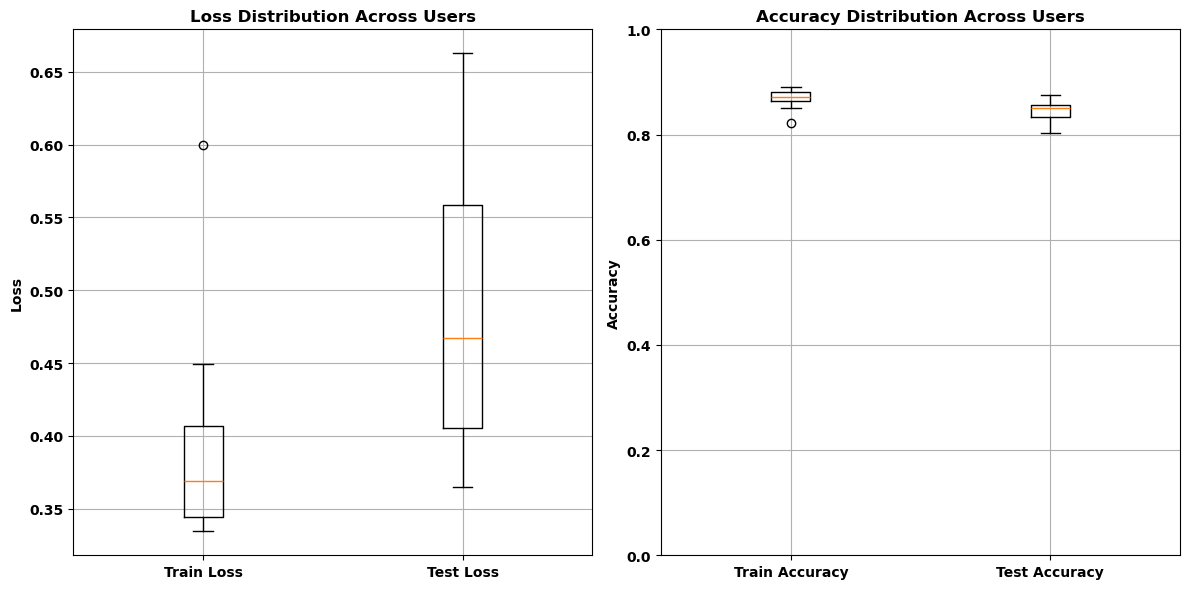

In [19]:
# Track metrics across all users
test_loss_histories = []
test_accuracy_histories = []
#train_loss_histories = []
#train_accuracy_histories = []

# Testing loop for all users
user_test_losses = []
user_test_accuracies = []
user_train_losses = []
user_train_accuracies = []

with torch.no_grad():  # Disable gradient computation for testing
    for user_id, model in enumerate(classifiers):
        model.eval()

        # Test metrics
        epoch_test_loss = 0.0
        correct_test_predictions = 0
        total_test_samples = 0

        # Train metrics (optional, for post-training evaluation on training data)
        epoch_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        # Evaluate on test set
        for X_batch, y_batch in test_loaders[user_id]:  # Assuming test_loader is a list of loaders for users
            #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            epoch_test_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_test_predictions += (predicted == y_batch).sum().item()
            total_test_samples += y_batch.size(0)
        # Evaluate on training set
        for X_batch, y_batch in train_loaders[user_id]:  # Assuming train_loader is available per user
            #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_train_predictions += (predicted == y_batch).sum().item()
            total_train_samples += y_batch.size(0)

        # Calculate averages
        avg_test_loss = epoch_test_loss / len(test_loaders[user_id])
        test_accuracy = correct_test_predictions / total_test_samples

        avg_train_loss = epoch_train_loss / len(train_loaders[user_id])
        train_accuracy = correct_train_predictions / total_train_samples

        # Store metrics for each user
        user_test_losses.append(avg_test_loss)
        user_test_accuracies.append(test_accuracy)
        user_train_losses.append(avg_train_loss)
        user_train_accuracies.append(train_accuracy)


# Store the average metrics across all users
test_loss_histories.append(user_test_losses)
test_accuracy_histories.append(user_test_accuracies)
#train_loss_histories.append(user_train_losses)
#train_accuracy_histories.append(user_train_accuracies)

# Print average metrics
print(f"\nAverage Test Loss: {np.mean(user_test_losses):.4f}, Average Test Accuracy: {np.mean(user_test_accuracies):.4f}")
print(f"\nAverage Train Loss: {np.mean(user_train_losses):.4f}, Average Train Accuracy: {np.mean(user_train_accuracies):.4f}")

# Convert metrics to numpy arrays for plotting
test_loss_histories = np.array(test_loss_histories)
test_accuracy_histories = np.array(test_accuracy_histories)
train_loss_histories = np.array(train_loss_histories)
train_accuracy_histories = np.array(train_accuracy_histories)

# Calculate means and standard deviations
test_loss_mean = test_loss_histories.mean(axis=1)
test_loss_std = test_loss_histories.std(axis=1)
test_acc_mean = test_accuracy_histories.mean(axis=1)
test_acc_std = test_accuracy_histories.std(axis=1)

train_loss_mean = train_loss_histories.mean(axis=1)
train_loss_std = train_loss_histories.std(axis=1)
train_acc_mean = train_accuracy_histories.mean(axis=1)
train_acc_std = train_accuracy_histories.std(axis=1)

# Box plot for final train and test loss
plt.figure(figsize=(12, 6))

# Loss box plot
plt.subplot(1, 2, 1)
plt.boxplot([train_loss_histories[-1], test_loss_histories[-1]], labels=["Train Loss", "Test Loss"])
plt.title("Loss Distribution Across Users")
plt.ylabel("Loss")
plt.grid()

# Accuracy box plot
plt.subplot(1, 2, 2)
plt.boxplot([train_accuracy_histories[-1], test_accuracy_histories[-1]], labels=["Train Accuracy", "Test Accuracy"])
plt.title("Accuracy Distribution Across Users")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Ensure y-axis is between 0 and 1 for accuracy
plt.grid()

plt.tight_layout()
plt.show()



In [20]:
# Images only
'''
Test Loss: 0.4364, Test Accuracy: 0.8521

Train Loss: 0.4047, Train Accuracy: 0.8687

'''

'\nTest Loss: 0.4364, Test Accuracy: 0.8521\n\nTrain Loss: 0.4047, Train Accuracy: 0.8687\n\n'

In [21]:
import json

metrics = {
    "train_loss_histories": train_loss_histories.tolist(),
    "train_accuracy_histories": train_accuracy_histories.tolist(),
    "val_loss_histories": val_loss_histories.tolist(),
    "val_accuracy_histories": val_accuracy_histories.tolist(),
    "test_loss_histories": test_loss_histories.tolist(),
    "test_accuracy_histories": test_accuracy_histories.tolist(),
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f)
print("Metrics saved to metrics.json")

Metrics saved to metrics.json


In [22]:
# Load metrics from JSON file
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Convert lists back to numpy arrays
train_loss_histories = np.array(metrics["train_loss_histories"])
train_accuracy_histories = np.array(metrics["train_accuracy_histories"])
val_loss_histories = np.array(metrics["val_loss_histories"])
val_accuracy_histories = np.array(metrics["val_accuracy_histories"])
test_loss_histories = np.array(metrics["test_loss_histories"])
test_accuracy_histories = np.array(metrics["test_accuracy_histories"])

# Print shapes to confirm loading
print("Train Loss Histories Shape:", train_loss_histories.shape)
print("Train Accuracy Histories Shape:", train_accuracy_histories.shape)
print("Validation Loss Histories Shape:", val_loss_histories.shape)
print("Validation Accuracy Histories Shape:", val_accuracy_histories.shape)
print("Test Loss Histories Shape:", test_loss_histories.shape)
print("Test Accuracy Histories Shape:", test_accuracy_histories.shape)

Train Loss Histories Shape: (100, 20)
Train Accuracy Histories Shape: (100, 20)
Validation Loss Histories Shape: (100, 20)
Validation Accuracy Histories Shape: (100, 20)
Test Loss Histories Shape: (1, 20)
Test Accuracy Histories Shape: (1, 20)
